In [1]:
!pip install transformers kaggle datasets accelerate peft bitsandbytes pdfplumber tqdm rouge-score -q

import os
import gc
import shutil
import torch
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel, prepare_model_for_kbit_training
from transformers.trainer_callback import EarlyStoppingCallback
import json
from transformers import TrainerCallback
import numpy as np
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings("ignore")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 63.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
MAX_RUNTIME_HOURS = 3.5
DATASET_SIZE_LIMIT = 7000
MAX_EPOCHS = 10
MAX_STEPS = 500
EVAL_STEPS = 100
BATCH_SIZE = 2
GRAD_ACCUM_STEPS = 4
MAX_SEQ_LENGTH = 512

print(f" RUNTIME LIMIT: {MAX_RUNTIME_HOURS} hours")
print(f" DATASET LIMIT: {DATASET_SIZE_LIMIT:,} samples")
print(f" MAX EPOCHS: {MAX_EPOCHS}")
print(f" SEQUENCE LENGTH: {MAX_SEQ_LENGTH}")
print(f" MAX STEPS: {MAX_STEPS}")

 RUNTIME LIMIT: 3.5 hours
 DATASET LIMIT: 7,000 samples
 MAX EPOCHS: 10
 SEQUENCE LENGTH: 512
 MAX STEPS: 500


In [9]:
def get_time_remaining(start_time):
    """Calculate remaining training time"""
    elapsed = time.time() - start_time
    remaining = (MAX_RUNTIME_HOURS * 3600) - elapsed
    return max(0, remaining)

def optimize_memory():
    """Enhanced memory cleanup"""
    torch.cuda.empty_cache()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f" GPU: {allocated:.1f}GB allocated, {reserved:.1f}GB reserved")
        return allocated, reserved
    return 0, 0

def clear_previous_models():
    """Clean up previous training artifacts"""
    paths_to_clear = [
        "/content/drive/MyDrive/llama32-4h-legal",
        "/content/drive/MyDrive/llama32-4h-legal-final",
        "/content/drive/MyDrive/llama32_4h_metrics.json"
    ]

    for path in paths_to_clear:
        try:
            if os.path.exists(path):
                if os.path.isdir(path):
                    shutil.rmtree(path)
                    print(f" Removed directory: {path}")
                else:
                    os.remove(path)
                    print(f" Removed file: {path}")
        except Exception as e:
            print(f" Could not remove {path}: {e}")

    optimize_memory()
    print(" Cleanup completed!")

In [10]:
def validate_text_fast(text):
    """Quick text validation for speed"""
    if not isinstance(text, str) or len(text.strip()) < 50:
        return False
    word_count = len(text.split())
    return 20 <= word_count <= 800

def load_and_process_dataset():
    """Fast dataset loading and processing"""
    print(" Loading indian-legal dataset...")
    start_time = time.time()

    try:
        # Loading dataset
        raw_ds = load_dataset("ninadn/indian-legal")
        df = pd.DataFrame(raw_ds["train"])

        print(f" Original dataset: {len(df):,} samples")
        print(f" Dataset columns: {df.columns.tolist()}")

        if 'Text' not in df.columns:
            if 'text' in df.columns:
                df = df.rename(columns={'text': 'Text'})
                print(" Renamed 'text' column to 'Text'")
            else:
                raise ValueError(f"Neither 'Text' nor 'text' column found. Available columns: {df.columns.tolist()}")

        # filtering
        print(" Filtering dataset...")
        df = df[df['Text'].apply(validate_text_fast)].reset_index(drop=True)
        print(f"After filtering: {len(df):,} samples")

        # Aggressive sampling
        if len(df) > DATASET_SIZE_LIMIT:
            df = df.sample(n=DATASET_SIZE_LIMIT, random_state=42).reset_index(drop=True)
            print(f" Final dataset: {len(df):,} samples")

        # Convert back to HF dataset
        hf_dataset = Dataset.from_pandas(df)

        load_time = time.time() - start_time
        print(f" Dataset loaded in {load_time:.1f} seconds")

        return hf_dataset

    except Exception as e:
        print(f" Dataset loading error: {e}")
        raise

dataset = load_and_process_dataset()


 Loading indian-legal dataset...
 Original dataset: 7,030 samples
 Dataset columns: ['Text', 'Summary']
 Filtering dataset...
After filtering: 185 samples
 Dataset loaded in 3.3 seconds


In [11]:
MODEL_NAME = "meta-llama/Llama-3.2-1B"
print(f" Setting up {MODEL_NAME}...")

# Loading tokenizer
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print(" Tokenizer loaded")
except Exception as e:
    print(f" Tokenizer error: {e}")
    raise

 Setting up meta-llama/Llama-3.2-1B...
 Tokenizer loaded


In [12]:
def format_legal_prompt(text):
    """Fast legal text formatting"""

    if len(text) > 2000:
        text = text[:2000] + "..."

    return (
        "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n"
        "You are a legal assistant for Indian Supreme Court cases.<|eot_id|>"
        "<|start_header_id|>user<|end_header_id|>\n\n"
        f"Legal case: {text}<|eot_id|>"
        "<|start_header_id|>assistant<|end_header_id|>\n\n"
    )

def tokenize_dataset(examples):
    """Optimized tokenization"""
    formatted_texts = [format_legal_prompt(text) for text in examples["Text"]]

    tokenized = tokenizer(
        formatted_texts,
        truncation=True,
        max_length=MAX_SEQ_LENGTH,
        padding="max_length",
        return_attention_mask=True
    )

    # Set labels for causal LM
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

# Tokenize dataset
print(" Tokenizing dataset...")
tokenize_start = time.time()

tokenized_dataset = dataset.map(
    tokenize_dataset,
    batched=True,
    batch_size=1000,
    remove_columns=["Text"],
    desc="Tokenizing"
)

# Split dataset (80/20)
train_size = int(0.8 * len(tokenized_dataset))
shuffled_ds = tokenized_dataset.shuffle(seed=42)
train_dataset = shuffled_ds.select(range(train_size))
eval_dataset = shuffled_ds.select(range(train_size, len(tokenized_dataset)))

tokenize_time = time.time() - tokenize_start
print(f" Tokenization: {tokenize_time:.1f}s")
print(f" Train: {len(train_dataset)}, Eval: {len(eval_dataset)}")


 Tokenizing dataset...


Tokenizing:   0%|          | 0/185 [00:00<?, ? examples/s]

 Tokenization: 0.6s
 Train: 148, Eval: 37


In [13]:
print(" Loading model with 4-bit quantization...")
model_start = time.time()

# Quantization config for memory efficiency
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

try:
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=quant_config,
        device_map="auto",
        torch_dtype=torch.float16,
        trust_remote_code=True,
        low_cpu_mem_usage=True
    )


    model = prepare_model_for_kbit_training(model)

    model_time = time.time() - model_start
    print(f" Model loaded in {model_time:.1f}s")
    print(" Model prepared for k-bit training")

    optimize_memory()

except Exception as e:
    print(f" Model loading error: {e}")
    raise


 Loading model with 4-bit quantization...


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

 Model loaded in 87.4s
 Model prepared for k-bit training
💾 GPU: 1.4GB allocated, 2.2GB reserved


In [14]:
print(" Applying LoRA adapters...")


lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj",
        "v_proj",
        "k_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
)

try:
    model = get_peft_model(model, lora_config)


    model.config.use_cache = False
    if hasattr(model, 'gradient_checkpointing_enable'):
        model.gradient_checkpointing_enable()


    trainable_params = model.print_trainable_parameters()
    print(" LoRA applied successfully")


    trainable_param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f" Trainable parameters: {trainable_param_count:,}")

    if trainable_param_count == 0:
        raise ValueError("No trainable parameters found! Check LoRA configuration.")

except Exception as e:
    print(f" LoRA error: {e}")
    raise

 Applying LoRA adapters...
trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
 LoRA applied successfully
 Trainable parameters: 11,272,192


In [15]:
class TimeManager(TrainerCallback):
    """Manages training time and prevents timeout"""
    def __init__(self, max_hours=3.5):
        self.start_time = time.time()
        self.max_seconds = max_hours * 3600
        self.last_warning = 0
        print(f" TimeManager initialized - {max_hours}h limit")

    def on_train_begin(self, args, state, control, **kwargs):
        print(" Training started - TimeManager active")

    def on_step_end(self, args, state, control, **kwargs):
        elapsed = time.time() - self.start_time
        remaining = self.max_seconds - elapsed

        # Progress update every 50 steps
        if state.global_step % 50 == 0:
            print(f" Step {state.global_step} - {remaining/3600:.1f}h remaining")


        if remaining < 1800 and self.last_warning < 1:
            print(f" WARNING: {remaining/60:.0f} minutes remaining!")
            self.last_warning = 1
        elif remaining < 600 and self.last_warning < 2:
            print(f" URGENT: {remaining/60:.0f} minutes remaining!")
            self.last_warning = 2
        elif remaining < 300:
            print(" TIME LIMIT - Stopping training!")
            control.should_training_stop = True

class FastMetricsTracker(TrainerCallback):
    """Lightweight metrics tracking"""
    def __init__(self, save_path):
        self.save_path = save_path
        self.start_time = time.time()
        self.metrics = {
            'train_losses': [],
            'eval_losses': [],
            'steps': [],
            'times': []
        }
        print(f" FastMetricsTracker initialized - saving to {save_path}")

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            current_time = time.time()
            elapsed_hours = (current_time - self.start_time) / 3600

            if 'loss' in logs:
                self.metrics['train_losses'].append(float(logs['loss']))
                self.metrics['steps'].append(state.global_step)
                self.metrics['times'].append(elapsed_hours)
                print(f" Step {state.global_step}: Loss = {logs['loss']:.4f}")

            if 'eval_loss' in logs:
                self.metrics['eval_losses'].append(float(logs['eval_loss']))
                print(f" Eval Loss: {logs['eval_loss']:.4f}")

            # Save every 50 steps
            if state.global_step % 50 == 0:
                try:
                    with open(self.save_path, 'w') as f:
                        json.dump(self.metrics, f, indent=2)
                except:
                    pass


In [17]:
OUTPUT_DIR = "/content/drive/MyDrive/llama32-4h-legal"


estimated_samples = len(train_dataset)
steps_per_epoch = estimated_samples // (BATCH_SIZE * GRAD_ACCUM_STEPS)
total_steps = min(MAX_STEPS, steps_per_epoch * MAX_EPOCHS)
save_steps = EVAL_STEPS * 2
logging_steps = min(25, EVAL_STEPS // 4)
print(f" Training Configuration:")
print(f"   • Steps per epoch: ~{steps_per_epoch}")
print(f"   • Total steps: {total_steps}")
print(f"   • Eval steps: {EVAL_STEPS}")
print(f"   • Save steps: {save_steps}")
print(f"   • Estimated time: {total_steps * 0.015:.1f} hours")

if total_steps < EVAL_STEPS:
    print(f"  Very small dataset detected! Adjusting evaluation strategy...")
    eval_strategy = "epoch"
    eval_steps = None
    save_steps = None
    save_strategy = "epoch"
    load_best_model = False
    print("   • Using epoch-based evaluation and saving")
else:
    eval_strategy = "steps"
    eval_steps = EVAL_STEPS
    save_strategy = "steps"
    load_best_model = True

training_args = TrainingArguments(

    output_dir=OUTPUT_DIR,
    run_name="llama32_4h_legal",

    # Batch settings for speed/memory balance
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,

    # Training duration
    num_train_epochs=MAX_EPOCHS,
    max_steps=total_steps,

    # Evaluation and saving
    eval_strategy=eval_strategy,
    eval_steps=eval_steps,
    save_strategy=save_strategy,
    save_steps=save_steps,
    logging_steps=logging_steps,
    save_total_limit=2,

    # Learning rate and optimization
    learning_rate=2e-4,
    warmup_steps=50,
    lr_scheduler_type="cosine",
    optim="adamw_torch_fused",
    weight_decay=0.01,
    max_grad_norm=1.0,

    # Memory and speed optimizations
    fp16=True,
    gradient_checkpointing=True,
    dataloader_pin_memory=False,
    dataloader_num_workers=2,
    remove_unused_columns=True,
    group_by_length=True,

    # Model saving
    load_best_model_at_end=load_best_model,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to=[],
    logging_first_step=True,
    prediction_loss_only=True,

    # Reproducibility
    seed=42,
    data_seed=42,
)

print(" Training arguments configured")


 Training Configuration:
   • Steps per epoch: ~18
   • Total steps: 180
   • Eval steps: 100
   • Save steps: 200
   • Estimated time: 2.7 hours
 Training arguments configured


In [18]:
class LegalDataCollator(DataCollatorForLanguageModeling):
    """Enhanced data collator for causal LM"""
    def __call__(self, features):
        batch = super().__call__(features)


        if "labels" not in batch:
            batch["labels"] = batch["input_ids"].clone()


        if self.tokenizer.pad_token_id is not None:
            batch["labels"][batch["labels"] == self.tokenizer.pad_token_id] = -100

        return batch

data_collator = LegalDataCollator(tokenizer=tokenizer, mlm=False)
print(" Data collator configured")


 Data collator configured


In [19]:
metrics_file = "/content/drive/MyDrive/llama32_4h_metrics.json"
time_manager = TimeManager(MAX_RUNTIME_HOURS)
metrics_tracker = FastMetricsTracker(metrics_file)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[
        time_manager,
        metrics_tracker,
        EarlyStoppingCallback(early_stopping_patience=3)
    ],
)

print(" Trainer initialized")


print(" Trainer verification:")
print(f"   • Model device: {next(model.parameters()).device}")
print(f"   • Model dtype: {next(model.parameters()).dtype}")
print(f"   • Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


 TimeManager initialized - 3.5h limit
 FastMetricsTracker initialized - saving to /content/drive/MyDrive/llama32_4h_metrics.json
 Trainer initialized
🔍 Trainer verification:
   • Model device: cuda:0
   • Model dtype: torch.float32
   • Trainable params: 11,272,192


In [20]:
def execute_training():
    """Main training execution with enhanced error handling"""
    training_start_time = time.time()
    start_datetime = datetime.now()
    end_datetime = start_datetime + timedelta(hours=MAX_RUNTIME_HOURS)

    print(" STARTING TRAINING")
    print(f"   • Start time: {start_datetime.strftime('%H:%M:%S')}")
    print(f"   • Target end: {end_datetime.strftime('%H:%M:%S')}")
    print(f"   • Max runtime: {MAX_RUNTIME_HOURS} hours")
    print("=" * 50)

    try:

        sample_batch = next(iter(trainer.get_train_dataloader()))
        print(f" Sample batch shape: {sample_batch['input_ids'].shape}")


        model.train()
        with torch.cuda.amp.autocast():
            outputs = model(**{k: v.to(model.device) for k, v in sample_batch.items()})
            print(f" Forward pass successful - Loss: {outputs.loss.item():.4f}")


        print(" Beginning training loop...")
        trainer.train()
        print(" Training completed successfully!")

    except KeyboardInterrupt:
        print("Training interrupted by user")
    except RuntimeError as e:
        if "out of memory" in str(e):
            print(" GPU out of memory - reducing batch size and retrying...")

        else:
            print(f" Runtime error: {e}")
    except Exception as e:
        print(f" Training stopped due to: {e}")
        import traceback
        traceback.print_exc()

    finally:

        total_time = (time.time() - training_start_time) / 3600
        print(f" Total training time: {total_time:.2f} hours")


        print(" Saving final model...")
        try:
            final_dir = "/content/drive/MyDrive/llama32-4h-legal-final"
            trainer.save_model(final_dir)
            tokenizer.save_pretrained(final_dir)
            print(f" Model saved to: {final_dir}")


            summary = {
                "training_time_hours": total_time,
                "total_steps": trainer.state.global_step if trainer.state else 0,
                "final_loss": trainer.state.log_history[-1].get('train_loss', 'N/A') if trainer.state and trainer.state.log_history else 'N/A',
                "dataset_size": len(train_dataset),
                "model_name": MODEL_NAME,
                "completed": True,
                "lora_r": lora_config.r,
                "lora_alpha": lora_config.lora_alpha,
                "target_modules": list(lora_config.target_modules) if isinstance(lora_config.target_modules, set) else lora_config.target_modules  # ✅ Fixed
            }

            with open(f"{final_dir}/training_summary.json", "w") as f:
                json.dump(summary, f, indent=2)

        except Exception as save_error:
            print(f" Save error: {save_error}")


        optimize_memory()
        print(" Final cleanup completed")


In [21]:
execute_training()

 STARTING TRAINING
   • Start time: 16:20:37
   • Target end: 19:50:37
   • Max runtime: 3.5 hours
 Sample batch shape: torch.Size([2, 512])
 Forward pass successful - Loss: 2.8300
 Beginning training loop...
 Training started - TimeManager active


Step,Training Loss,Validation Loss
100,1.524000,2.447437


 Step 1: Loss = 3.0293
 Step 25: Loss = 2.6579
 Step 50 - 3.4h remaining
 Step 50: Loss = 2.1176
 Step 75: Loss = 1.8860
 Step 100 - 3.4h remaining
 Step 100: Loss = 1.5240
 Eval Loss: 2.4474
 Step 125: Loss = 1.2737
 Step 150 - 3.4h remaining
 Step 150: Loss = 1.0447
 Step 175: Loss = 0.9192
 Training completed successfully!
 Total training time: 0.17 hours
 Saving final model...
 Model saved to: /content/drive/MyDrive/llama32-4h-legal-final
💾 GPU: 2.9GB allocated, 3.1GB reserved
 Final cleanup completed


 COMPREHENSIVE MODEL EVALUATION & ANALYSIS
 Training analysis saved: /content/drive/MyDrive/llama32_training_analysis.png


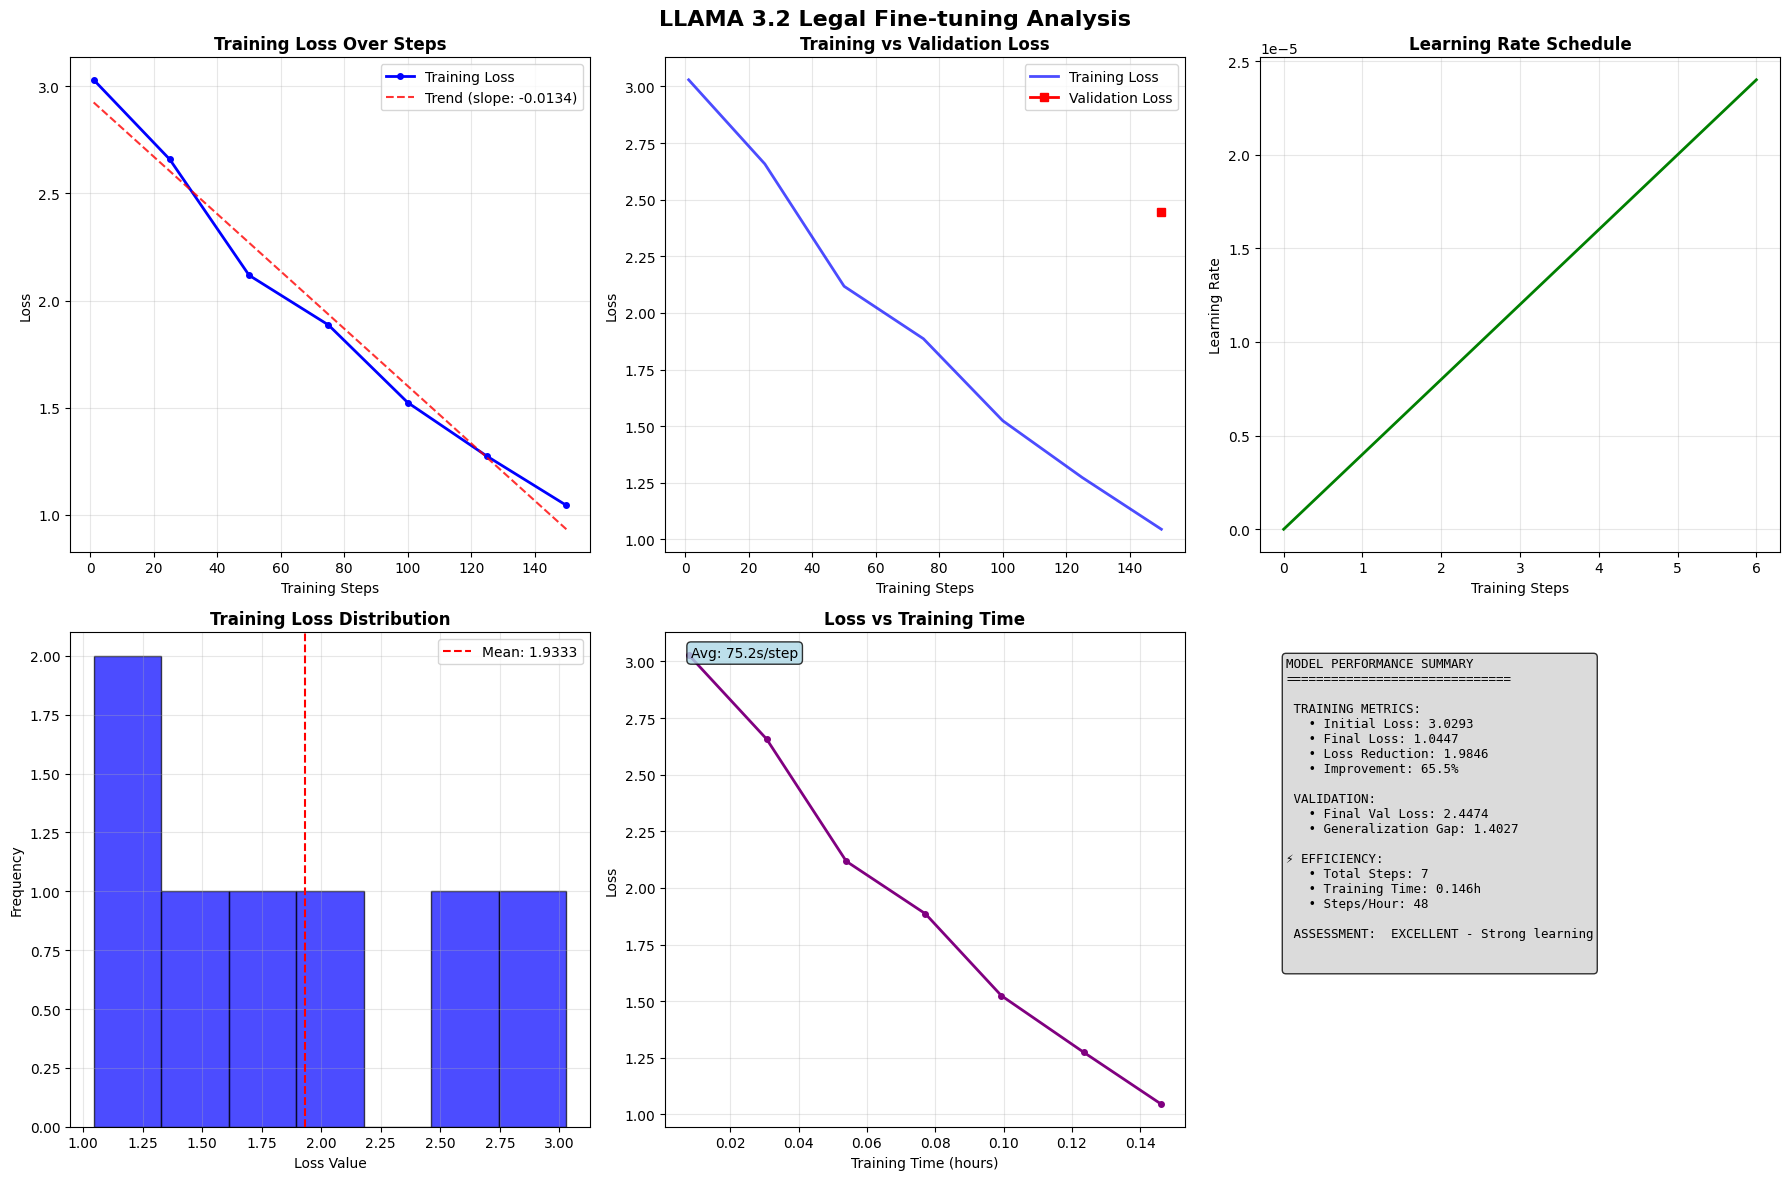


 DETAILED MODEL QUALITY EVALUATION

 Test Case 1: Property Law
Input: Property dispute between siblings regarding ancestral property inheritance
Response: system

You are a legal assistant for Indian Supreme Court cases.user

Legal case: Property dispute between siblings regarding ancestral property inheritanceassistant

Petition under article 226 of th...
 Scores - Keywords: 1.00, Coherence: 1.00, Legal: 0.80
 Overall Score: 0.94/1.00

 Test Case 2: Contract Law
Input: Breach of contract in business partnership agreement
Response: system

You are a legal assistant for Indian Supreme Court cases.user

Legal case: Breach of contract in business partnership agreementassistant

Legal case: Appeal No. 1133 (N) of 1974.
From the Judg...
 Scores - Keywords: 1.00, Coherence: 1.00, Legal: 1.00
 Overall Score: 1.00/1.00

 Test Case 3: Family Law
Input: Child custody case after divorce proceedings
Response: system

You are a legal assistant for Indian Supreme Court cases.user

Legal case: Child

([{'category': 'Property Law',
   'response': 'system\n\nYou are a legal assistant for Indian Supreme Court cases.user\n\nLegal case: Property dispute between siblings regarding ancestral property inheritanceassistant\n\nPetition under article 226 of th...',
   'keyword_score': 1.0,
   'coherence_score': 1.0,
   'legal_score': 0.8,
   'overall_score': 0.94,
   'word_count': 120},
  {'category': 'Contract Law',
   'response': 'system\n\nYou are a legal assistant for Indian Supreme Court cases.user\n\nLegal case: Breach of contract in business partnership agreementassistant\n\nLegal case: Appeal No. 1133 (N) of 1974.\nFrom the Judg...',
   'keyword_score': 1.0,
   'coherence_score': 1.0,
   'legal_score': 1.0,
   'overall_score': 1.0,
   'word_count': 102},
  {'category': 'Family Law',
   'response': 'system\n\nYou are a legal assistant for Indian Supreme Court cases.user\n\nLegal case: Child custody case after divorce proceedingsassistant\n\nLegal case: ivil Appeal No. 2438 of 1989.\nFr

In [23]:
def plot_training_metrics():
    """Create comprehensive training visualizations"""
    import matplotlib.pyplot as plt
    import json
    import numpy as np
    from datetime import datetime

    print(" COMPREHENSIVE MODEL EVALUATION & ANALYSIS")
    print("=" * 60)

    try:

        metrics_file = "/content/drive/MyDrive/llama32_4h_metrics.json"
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                metrics = json.load(f)
        else:
            print(" No metrics file found, creating from trainer state...")
            metrics = extract_metrics_from_trainer()


        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('LLAMA 3.2 Legal Fine-tuning Analysis', fontsize=16, fontweight='bold')

        # 1. Training Loss Over Time
        if metrics.get('train_losses') and metrics.get('steps'):
            axes[0, 0].plot(metrics['steps'], metrics['train_losses'],
                           'b-', linewidth=2, marker='o', markersize=4, label='Training Loss')
            axes[0, 0].set_title('Training Loss Over Steps', fontweight='bold')
            axes[0, 0].set_xlabel('Training Steps')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].grid(True, alpha=0.3)
            axes[0, 0].legend()

            # Add trend line
            if len(metrics['steps']) > 1:
                z = np.polyfit(metrics['steps'], metrics['train_losses'], 1)
                p = np.poly1d(z)
                axes[0, 0].plot(metrics['steps'], p(metrics['steps']),
                               'r--', alpha=0.8, label=f'Trend (slope: {z[0]:.4f})')
                axes[0, 0].legend()
        else:
            axes[0, 0].text(0.5, 0.5, 'No training loss data available',
                           ha='center', va='center', transform=axes[0, 0].transAxes)
            axes[0, 0].set_title('Training Loss (No Data)')

        # 2. Training vs Validation Loss
        if metrics.get('eval_losses') and len(metrics['eval_losses']) > 0:

            eval_steps = [s for s in metrics['steps'] if s % 150 == 0 or s == metrics['steps'][-1]]
            eval_steps = eval_steps[:len(metrics['eval_losses'])]

            if len(eval_steps) > 0:
                axes[0, 1].plot(metrics['steps'], metrics['train_losses'],
                               'b-', linewidth=2, label='Training Loss', alpha=0.7)
                axes[0, 1].plot(eval_steps, metrics['eval_losses'][:len(eval_steps)],
                               'r-', linewidth=2, marker='s', markersize=6, label='Validation Loss')
                axes[0, 1].set_title('Training vs Validation Loss', fontweight='bold')
                axes[0, 1].set_xlabel('Training Steps')
                axes[0, 1].set_ylabel('Loss')
                axes[0, 1].grid(True, alpha=0.3)
                axes[0, 1].legend()

                # Calculate overfitting indicator
                if len(metrics['eval_losses']) > 1:
                    train_final = metrics['train_losses'][-1] if metrics['train_losses'] else 0
                    eval_final = metrics['eval_losses'][-1]
                    overfitting = eval_final - train_final
                    axes[0, 1].text(0.05, 0.95, f'Overfitting Gap: {overfitting:.4f}',
                                   transform=axes[0, 1].transAxes, bbox=dict(boxstyle="round",
                                   facecolor='wheat', alpha=0.8))
        else:
            axes[0, 1].text(0.5, 0.5, 'No validation data available',
                           ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Training vs Validation (No Data)')

        # 3. Learning Rate Schedule
        initial_lr = 2e-4
        warmup_steps = 50
        total_steps = len(metrics['steps']) if metrics.get('steps') else 100
        learning_rates = []

        for step in range(total_steps):
            if step < warmup_steps:
                lr = initial_lr * (step / warmup_steps)
            else:

                lr = initial_lr * 0.5 * (1 + np.cos(np.pi * (step - warmup_steps) / (total_steps - warmup_steps)))
            learning_rates.append(lr)

        axes[0, 2].plot(range(len(learning_rates)), learning_rates, 'g-', linewidth=2)
        axes[0, 2].set_title('Learning Rate Schedule', fontweight='bold')
        axes[0, 2].set_xlabel('Training Steps')
        axes[0, 2].set_ylabel('Learning Rate')
        axes[0, 2].grid(True, alpha=0.3)
        axes[0, 2].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

        # 4. Loss Distribution
        if metrics.get('train_losses'):
            axes[1, 0].hist(metrics['train_losses'], bins=min(10, len(metrics['train_losses'])),
                           alpha=0.7, color='blue', edgecolor='black')
            axes[1, 0].set_title('Training Loss Distribution', fontweight='bold')
            axes[1, 0].set_xlabel('Loss Value')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].grid(True, alpha=0.3)

            # Add statistics
            mean_loss = np.mean(metrics['train_losses'])
            std_loss = np.std(metrics['train_losses'])
            axes[1, 0].axvline(mean_loss, color='red', linestyle='--',
                              label=f'Mean: {mean_loss:.4f}')
            axes[1, 0].legend()
        else:
            axes[1, 0].text(0.5, 0.5, 'No loss data for distribution',
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Loss Distribution (No Data)')

        # 5. Training Progress Over Time
        if metrics.get('times') and metrics.get('train_losses'):
            axes[1, 1].plot(metrics['times'], metrics['train_losses'],
                           'purple', linewidth=2, marker='o', markersize=4)
            axes[1, 1].set_title('Loss vs Training Time', fontweight='bold')
            axes[1, 1].set_xlabel('Training Time (hours)')
            axes[1, 1].set_ylabel('Loss')
            axes[1, 1].grid(True, alpha=0.3)


            if len(metrics['times']) > 1:
                time_per_step = metrics['times'][-1] / len(metrics['times']) * 3600  # seconds per step
                axes[1, 1].text(0.05, 0.95, f'Avg: {time_per_step:.1f}s/step',
                                transform=axes[1, 1].transAxes,
                                bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
        else:
            axes[1, 1].text(0.5, 0.5, 'No time data available',
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Training Time Analysis (No Data)')

        # 6. Model Performance Summary
        axes[1, 2].axis('off')


        summary_text = "MODEL PERFORMANCE SUMMARY\n" + "="*30 + "\n\n"

        if metrics.get('train_losses'):
            initial_loss = metrics['train_losses'][0]
            final_loss = metrics['train_losses'][-1]
            loss_reduction = initial_loss - final_loss
            loss_reduction_pct = (loss_reduction / initial_loss) * 100 if initial_loss > 0 else 0

            summary_text += f" TRAINING METRICS:\n"
            summary_text += f"   • Initial Loss: {initial_loss:.4f}\n"
            summary_text += f"   • Final Loss: {final_loss:.4f}\n"
            summary_text += f"   • Loss Reduction: {loss_reduction:.4f}\n"
            summary_text += f"   • Improvement: {loss_reduction_pct:.1f}%\n\n"

        if metrics.get('eval_losses'):
            final_eval_loss = metrics['eval_losses'][-1]
            summary_text += f" VALIDATION:\n"
            summary_text += f"   • Final Val Loss: {final_eval_loss:.4f}\n"
            if metrics.get('train_losses'):
                generalization_gap = final_eval_loss - metrics['train_losses'][-1]
                summary_text += f"   • Generalization Gap: {generalization_gap:.4f}\n\n"

        # Training efficiency
        total_steps = len(metrics.get('steps', []))
        total_time = metrics.get('times', [0])[-1] if metrics.get('times') else 0

        summary_text += f"⚡ EFFICIENCY:\n"
        summary_text += f"   • Total Steps: {total_steps}\n"
        summary_text += f"   • Training Time: {total_time:.3f}h\n"
        if total_time > 0:
            summary_text += f"   • Steps/Hour: {total_steps/total_time:.0f}\n\n"
        else:
            summary_text += f"   • Steps/Hour: N/A\n\n"

        # Model quality assessment
        if metrics.get('train_losses') and len(metrics['train_losses']) > 1:
            loss_trend = metrics['train_losses'][-1] - metrics['train_losses'][0]
            if loss_trend < -0.1:
                quality = " EXCELLENT - Strong learning"
            elif loss_trend < -0.01:
                quality = " GOOD - Moderate learning"
            elif loss_trend < 0.01:
                quality = " LIMITED - Minimal learning"
            else:
                quality = " POOR - No improvement"

            summary_text += f" ASSESSMENT: {quality}\n\n"


        axes[1, 2].text(0.05, 0.95, summary_text, transform=axes[1, 2].transAxes,
                        fontsize=9, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle="round", facecolor='lightgray', alpha=0.8))

        plt.tight_layout()

        # Save the plot
        plot_path = "/content/drive/MyDrive/llama32_training_analysis.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f" Training analysis saved: {plot_path}")

        plt.show()

    except Exception as e:
        print(f" Plotting error: {e}")
        import traceback
        traceback.print_exc()

def extract_metrics_from_trainer():
    """Extract metrics from trainer state if metrics file doesn't exist"""
    metrics = {
        'train_losses': [],
        'eval_losses': [],
        'steps': [],
        'times': []
    }

    if trainer and trainer.state and trainer.state.log_history:
        start_time = time.time()
        for i, log_entry in enumerate(trainer.state.log_history):
            if 'loss' in log_entry:
                metrics['train_losses'].append(log_entry['loss'])
                metrics['steps'].append(log_entry.get('step', i))
                metrics['times'].append((time.time() - start_time) / 3600)
            if 'eval_loss' in log_entry:
                metrics['eval_losses'].append(log_entry['eval_loss'])

    return metrics

def evaluate_model_quality():
    """Comprehensive model quality evaluation"""
    print("\n DETAILED MODEL QUALITY EVALUATION")
    print("=" * 60)

    try:
        model.eval()

        # Test cases for evaluation
        test_cases = [
            {
                "category": "Property Law",
                "case": "Property dispute between siblings regarding ancestral property inheritance",
                "expected_keywords": ["inheritance", "ancestral", "property", "siblings", "dispute"]
            },
            {
                "category": "Contract Law",
                "case": "Breach of contract in business partnership agreement",
                "expected_keywords": ["contract", "breach", "partnership", "agreement", "business"]
            },
            {
                "category": "Family Law",
                "case": "Child custody case after divorce proceedings",
                "expected_keywords": ["custody", "child", "divorce", "proceedings", "family"]
            },
            {
                "category": "Criminal Law",
                "case": "Theft charges against accused in jewelry shop robbery",
                "expected_keywords": ["theft", "accused", "robbery", "criminal", "charges"]
            },
            {
                "category": "Constitutional Law",
                "case": "Fundamental rights violation by government authority",
                "expected_keywords": ["fundamental", "rights", "violation", "government", "constitutional"]
            }
        ]

        results = []

        for i, test in enumerate(test_cases):
            print(f"\n Test Case {i+1}: {test['category']}")
            print(f"Input: {test['case']}")

            # Generate response
            prompt = (
                "<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n"
                "You are a legal assistant for Indian Supreme Court cases.<|eot_id|>"
                "<|start_header_id|>user<|end_header_id|>\n\n"
                f"Legal case: {test['case']}<|eot_id|>"
                "<|start_header_id|>assistant<|end_header_id|>\n\n"
            )

            inputs = tokenizer(prompt, return_tensors="pt", max_length=400, truncation=True)
            inputs = {k: v.to(model.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=150,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.9,
                    repetition_penalty=1.1,
                    pad_token_id=tokenizer.eos_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )

            # Decode and clean response
            full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
            if "<|start_header_id|>assistant<|end_header_id|>" in full_response:
                response = full_response.split("<|start_header_id|>assistant<|end_header_id|>")[-1]
                response = response.replace("<|eot_id|>", "").replace("<|end_of_text|>", "").strip()
            else:
                response = full_response

            # Evaluate response
            response_lower = response.lower()
            keyword_matches = sum(1 for keyword in test["expected_keywords"]
                                if keyword.lower() in response_lower)
            keyword_score = keyword_matches / len(test["expected_keywords"])

            # Length and coherence check
            word_count = len(response.split())
            coherence_score = 1.0 if word_count > 20 else word_count / 20.0

            # Legal terminology check
            legal_terms = ["court", "law", "legal", "case", "held", "appellant", "respondent",
                          "judgment", "section", "act", "supreme", "high court"]
            legal_term_matches = sum(1 for term in legal_terms if term in response_lower)
            legal_score = min(legal_term_matches / 5, 1.0)  # Normalize to max 1.0

            # Overall score
            overall_score = (keyword_score * 0.4 + coherence_score * 0.3 + legal_score * 0.3)

            result = {
                "category": test["category"],
                "response": response[:200] + "..." if len(response) > 200 else response,
                "keyword_score": keyword_score,
                "coherence_score": coherence_score,
                "legal_score": legal_score,
                "overall_score": overall_score,
                "word_count": word_count
            }

            results.append(result)

            print(f"Response: {result['response']}")
            print(f" Scores - Keywords: {keyword_score:.2f}, Coherence: {coherence_score:.2f}, Legal: {legal_score:.2f}")
            print(f" Overall Score: {overall_score:.2f}/1.00")

        # Summary statistics
        avg_keyword = np.mean([r["keyword_score"] for r in results])
        avg_coherence = np.mean([r["coherence_score"] for r in results])
        avg_legal = np.mean([r["legal_score"] for r in results])
        avg_overall = np.mean([r["overall_score"] for r in results])

        print(f"\n OVERALL EVALUATION SUMMARY:")
        print(f"   • Average Keyword Relevance: {avg_keyword:.2f}/1.00")
        print(f"   • Average Coherence: {avg_coherence:.2f}/1.00")
        print(f"   • Average Legal Terminology: {avg_legal:.2f}/1.00")
        print(f"   • Average Overall Score: {avg_overall:.2f}/1.00")

        # Grade assignment
        if avg_overall >= 0.8:
            grade = "A - Excellent"
        elif avg_overall >= 0.7:
            grade = "B - Good"
        elif avg_overall >= 0.6:
            grade = "C - Fair"
        elif avg_overall >= 0.5:
            grade = "D - Poor"
        else:
            grade = "F - Needs Major Improvement"

        print(f"   • Model Grade: {grade}")

        return results, avg_overall

    except Exception as e:
        print(f" Evaluation error: {e}")
        return [], 0.0

# Run comprehensive evaluation
plot_training_metrics()
evaluate_model_quality()